<a href="https://colab.research.google.com/github/htsnet/automacao-de-negocios/blob/master/Automacao_de_Negocios_Avaliacao_dos_Meses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automação de Negócios

Projeto de Automação de Negócios com Inteligência Artificial

Este projeto tem como objetivo a geração de um modelo que permita a automação de decisões de negócios no mercado financeiro.

Baseia-se em uma tabela histórica de simulações de operações financeiras realizadas com base em dados obtidos da B3 – a bolsa de valores brasileira.

As operações financeiras se referem à compra e venda do derivativo dólar futuro (DOL). São também conhecidas como operações de “Day Trade” no mercado futuro.

Descrição dos campos:

- CodOp = Código interno da operação (sem significado)
- Hora Entrada = Hora da compra
- Hora Saída = Hora da venda
- Duração = Intervalo de tempo entre entrada e saída do trade
- Data = Data da operação
- Pentrada = Preço do ativo no momento da compra
- Psaida = Preço do ativo no momento da venda
- Ganhos = Diferença de pontos entre compra e venda, se >= 0
- Perdas = Diferença de pontos entre compra e venda, se < 0
- Resultado = Resultado da operação (1 = ganho, 2 = perda) <-- target
- Ganho Trade =
- K entra = sumarização da hora de entrada, em minutos, a partir do início do pregão
- K Saida = sumarização da hora de saida, em minutos, a partir do início do pregão
- Item 1 = classificador número 1
- Item 2 = classificador número 2
- ...
- Item 77 = classificador número 77

Os campos da tabela que envolvem Data, Hora e Preço são dados históricos obtidos diretamente através da B3. Já os classificadores (Item 1 até Item 77, por exemplo) são calculados pelos proprietários do projeto, de acordo com a análise técnica desenvolvida por estes.

Obs. Todos os classificadores são numéricos e sem valores nulos.

A diferença entre os 2 arquivos disponibilizados é na estrutura dos campos. A quantidade de linhas é a mesma. Ambos podem ser utilizados no notebook, bastando apenas trocar o nome para o uoload.

A ideia do projeto tem como seus proprietário Farley Souza e Agnaldo Clozer Pinheiro. A análise do problema e o desenvolvimento do modelo é de Hamilton Tenório da Silva.



# Início: Importação as bibliotecas e Arquivo
É preciso carregar um arquivo CSV com o padrão definido para execução do notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib.pyplot import figure
from datetime import datetime
import pickle

In [2]:
#carrega a tabela de dados
#separador de campos = ;
#ponto decimal = ,
historic = pd.read_csv("/content/Amostra Completa - Mercado Futuro.csv", sep=";", decimal=",")
historic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39068 entries, 0 to 39067
Data columns (total 90 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CodOp         39068 non-null  int64  
 1   Hora Entrada  39068 non-null  object 
 2   Hora Saida    39068 non-null  object 
 3   Duração       39068 non-null  object 
 4   Data          39068 non-null  object 
 5   Pentrada      39068 non-null  float64
 6   Psaida        39068 non-null  float64
 7   Ganhos        39068 non-null  float64
 8   Perdas        39068 non-null  float64
 9   Resultado     39068 non-null  int64  
 10  Saldo Trade   39068 non-null  float64
 11  K entra       39068 non-null  int64  
 12  K Saida       39068 non-null  int64  
 13  Item 1        39068 non-null  int64  
 14  Item 2        39068 non-null  int64  
 15  Item 3        39068 non-null  float64
 16  Item 4        39068 non-null  int64  
 17  Item 5        39068 non-null  float64
 18  Item 6        39068 non-nu

In [3]:
#mostra os primeiros registros
historic.head()

,CodOp,Hora Entrada,Hora Saida,Duração,Data,Pentrada,Psaida,Ganhos,Perdas,Resultado,Saldo Trade,K entra,K Saida,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,...,Item 38,Item 39,Item 40,Item 41,Item 42,Item 43,Item 44,Item 45,Item 46,Item 47,Item 48,Item 49,Item 50,Item 51,Item 52,Item 53,Item 54,Item 55,Item 56,Item 57,Item 58,Item 59,Item 60,Item 61,Item 62,Item 63,Item 64,Item 65,Item 66,Item 67,Item 68,Item 69,Item 70,Item 71,Item 72,Item 73,Item 74,Item 75,Item 76,Item 77
0,9601,11:00:14,11:14:14,00:13:59,02/01/2019,3876.5,3862.5,0.0,14.0,2,-14.0,120,135,54400,-1800,-11.5,24,460.0,460.0,460.0,460.0,280.0,6800.0,9000.0,11400.0,22.0,52.0,40.5,37.5,-11.0,-6.0,-4.0,1.0,-1.0,-2.0,-58,-0.52,-66,-0.84,-60,...,-0.80,33,39,41,27,37,44,0,100,500,5,15,5,0,0,-1500,10,10,440,-11,-4.0,-8.5,-9.5,-7.0,-8.5,-9.5,-6.5,-2.0,-1.0,-3.5,-2.0,-1.0,-3.0,0.0,-1.0,0.0,0.0,0.0,2.9,5.4
1,9602,11:01:15,11:14:29,00:13:14,02/01/2019,3874.5,3859.0,0.0,15.5,2,-15.5,120,135,57600,-2200,-13.5,24,460.0,460.0,460.0,460.0,480.0,6800.0,9000.0,11400.0,38.0,52.0,40.5,37.5,-13.0,-7.0,-4.0,-4.0,-4.0,-2.0,4,0.08,-68,-0.88,-64,...,-0.86,33,37,36,27,34,41,200,700,500,5,0,5,0,-2800,-1500,90,6690,440,-12,-5.0,-10.5,-11.5,-8.5,-11.0,-11.5,-7.5,-2.0,-1.0,-4.0,-1.5,-1.0,-3.5,-0.5,-1.0,0.0,0.0,0.0,2.9,5.4
2,9603,11:02:16,11:19:46,00:17:30,02/01/2019,3872.5,3858.0,0.0,14.5,2,-14.5,120,140,57600,-2400,-15.5,24,470.0,460.0,460.0,460.0,1160.0,6800.0,9000.0,11400.0,78.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-5.0,-4.0,-1.0,-54,-0.82,-70,-0.92,-68,...,-0.90,19,38,29,25,34,36,200,200,1000,15,5,0,0,-400,-5500,20,110,19650,-14,-5.5,-11.5,-14.5,-9.5,-12.5,-14.5,-8.5,-2.5,0.5,-4.5,-2.0,0.5,-4.0,-1.0,-2.5,0.0,0.0,0.0,2.0,5.4
3,9604,11:03:18,11:19:46,00:16:28,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,57600,-2400,-16.0,24,480.0,460.0,460.0,460.0,1720.0,6800.0,9000.0,11400.0,116.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.94,-68,-0.90,-68,...,-0.92,18,33,28,26,31,35,-100,100,1000,0,5,0,-800,0,-5500,170,20,19650,-14,-4.5,-12.5,-15.0,-9.5,-13.0,-15.0,-9.5,-1.5,0.5,-5.0,-1.0,0.5,-5.0,-0.5,-2.5,0.0,0.0,0.0,1.8,5.4
4,9605,11:04:39,11:19:46,00:15:07,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,60800,-2400,-16.0,24,480.0,460.0,460.0,460.0,680.0,6800.0,9000.0,11400.0,36.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.96,-66,-0.88,-68,...,-0.94,21,37,29,23,38,36,0,100,1000,5,5,0,0,0,-5500,20,20,19650,-14,-3.5,-12.5,-15.0,-8.5,-12.5,-15.0,-10.5,-1.5,0.5,-5.5,-1.5,0.5,-5.0,0.0,-2.5,0.0,0.0,0.0,1.6,5.4


In [4]:
for i in range(1,50):
  print(historic['Data'])

0        02/01/2019
1        02/01/2019
2        02/01/2019
3        02/01/2019
4        02/01/2019
            ...    
39063    30/12/2019
39064    30/12/2019
39065    30/12/2019
39066    30/12/2019
39067    30/12/2019
Name: Data, Length: 39068, dtype: object
0        02/01/2019
1        02/01/2019
2        02/01/2019
3        02/01/2019
4        02/01/2019
            ...    
39063    30/12/2019
39064    30/12/2019
39065    30/12/2019
39066    30/12/2019
39067    30/12/2019
Name: Data, Length: 39068, dtype: object
0        02/01/2019
1        02/01/2019
2        02/01/2019
3        02/01/2019
4        02/01/2019
            ...    
39063    30/12/2019
39064    30/12/2019
39065    30/12/2019
39066    30/12/2019
39067    30/12/2019
Name: Data, Length: 39068, dtype: object
0        02/01/2019
1        02/01/2019
2        02/01/2019
3        02/01/2019
4        02/01/2019
            ...    
39063    30/12/2019
39064    30/12/2019
39065    30/12/2019
39066    30/12/2019
39067    30/12/20

In [5]:
#converte o campo data (string) em formato de data
historic['DataFormatada'] = pd.to_datetime(historic['Data'], format='%d/%m/%Y')
historic.head()

,CodOp,Hora Entrada,Hora Saida,Duração,Data,Pentrada,Psaida,Ganhos,Perdas,Resultado,Saldo Trade,K entra,K Saida,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,...,Item 39,Item 40,Item 41,Item 42,Item 43,Item 44,Item 45,Item 46,Item 47,Item 48,Item 49,Item 50,Item 51,Item 52,Item 53,Item 54,Item 55,Item 56,Item 57,Item 58,Item 59,Item 60,Item 61,Item 62,Item 63,Item 64,Item 65,Item 66,Item 67,Item 68,Item 69,Item 70,Item 71,Item 72,Item 73,Item 74,Item 75,Item 76,Item 77,DataFormatada
0,9601,11:00:14,11:14:14,00:13:59,02/01/2019,3876.5,3862.5,0.0,14.0,2,-14.0,120,135,54400,-1800,-11.5,24,460.0,460.0,460.0,460.0,280.0,6800.0,9000.0,11400.0,22.0,52.0,40.5,37.5,-11.0,-6.0,-4.0,1.0,-1.0,-2.0,-58,-0.52,-66,-0.84,-60,...,33,39,41,27,37,44,0,100,500,5,15,5,0,0,-1500,10,10,440,-11,-4.0,-8.5,-9.5,-7.0,-8.5,-9.5,-6.5,-2.0,-1.0,-3.5,-2.0,-1.0,-3.0,0.0,-1.0,0.0,0.0,0.0,2.9,5.4,2019-01-02
1,9602,11:01:15,11:14:29,00:13:14,02/01/2019,3874.5,3859.0,0.0,15.5,2,-15.5,120,135,57600,-2200,-13.5,24,460.0,460.0,460.0,460.0,480.0,6800.0,9000.0,11400.0,38.0,52.0,40.5,37.5,-13.0,-7.0,-4.0,-4.0,-4.0,-2.0,4,0.08,-68,-0.88,-64,...,33,37,36,27,34,41,200,700,500,5,0,5,0,-2800,-1500,90,6690,440,-12,-5.0,-10.5,-11.5,-8.5,-11.0,-11.5,-7.5,-2.0,-1.0,-4.0,-1.5,-1.0,-3.5,-0.5,-1.0,0.0,0.0,0.0,2.9,5.4,2019-01-02
2,9603,11:02:16,11:19:46,00:17:30,02/01/2019,3872.5,3858.0,0.0,14.5,2,-14.5,120,140,57600,-2400,-15.5,24,470.0,460.0,460.0,460.0,1160.0,6800.0,9000.0,11400.0,78.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-5.0,-4.0,-1.0,-54,-0.82,-70,-0.92,-68,...,19,38,29,25,34,36,200,200,1000,15,5,0,0,-400,-5500,20,110,19650,-14,-5.5,-11.5,-14.5,-9.5,-12.5,-14.5,-8.5,-2.5,0.5,-4.5,-2.0,0.5,-4.0,-1.0,-2.5,0.0,0.0,0.0,2.0,5.4,2019-01-02
3,9604,11:03:18,11:19:46,00:16:28,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,57600,-2400,-16.0,24,480.0,460.0,460.0,460.0,1720.0,6800.0,9000.0,11400.0,116.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.94,-68,-0.90,-68,...,18,33,28,26,31,35,-100,100,1000,0,5,0,-800,0,-5500,170,20,19650,-14,-4.5,-12.5,-15.0,-9.5,-13.0,-15.0,-9.5,-1.5,0.5,-5.0,-1.0,0.5,-5.0,-0.5,-2.5,0.0,0.0,0.0,1.8,5.4,2019-01-02
4,9605,11:04:39,11:19:46,00:15:07,02/01/2019,3872.0,3858.0,0.0,14.0,2,-14.0,125,140,60800,-2400,-16.0,24,480.0,460.0,460.0,460.0,680.0,6800.0,9000.0,11400.0,36.0,52.0,40.5,37.5,-16.0,-8.0,-5.0,-1.0,-1.0,-1.0,-64,-0.96,-66,-0.88,-68,...,21,37,29,23,38,36,0,100,1000,5,5,0,0,0,-5500,20,20,19650,-14,-3.5,-12.5,-15.0,-8.5,-12.5,-15.0,-10.5,-1.5,0.5,-5.5,-1.5,0.5,-5.0,0.0,-2.5,0.0,0.0,0.0,1.6,5.4,2019-01-02


In [33]:
#separa um mês em cada  dataframe e faz todas as operações de preparação do daframe criado
variables = locals()
for i in range(1,13):
  mes = str(i).zfill(2)
  variables["mes{0}".format(mes)] = historic[historic['DataFormatada'].dt.month == i]
  #separa o target e o código da operação
  variables["target{0}".format(mes)] = variables["mes{0}".format(mes)][['CodOp', 'Resultado']].copy()
  #indica o campo CodOp como índice nos 2 dataframes (para conferência futura)
  variables["mes{0}".format(mes)] = variables["mes{0}".format(mes)].set_index('CodOp')
  variables["target{0}".format(mes)] = variables["target{0}".format(mes)].set_index('CodOp')
  #apaga o campo target do dataframe original e outros campos já definidos como não necessários
  variables["mes{0}".format(mes)] = variables["mes{0}".format(mes)].drop(['Resultado', 'Hora Entrada', 'Hora Saida',
                                                                          'Duração', 'Data', 'Pentrada', 'Psaida', 'Ganhos',
                                                                          'Perdas', 'Saldo Trade', 'K entra', 'K Saida', 'DataFormatada'], axis=1)

mes02.head()    

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32,Item 33,Item 34,Item 35,Item 36,Item 37,Item 38,Item 39,Item 40,Item 41,Item 42,Item 43,Item 44,Item 45,Item 46,Item 47,Item 48,Item 49,Item 50,Item 51,Item 52,Item 53,Item 54,Item 55,Item 56,Item 57,Item 58,Item 59,Item 60,Item 61,Item 62,Item 63,Item 64,Item 65,Item 66,Item 67,Item 68,Item 69,Item 70,Item 71,Item 72,Item 73,Item 74,Item 75,Item 76,Item 77
CodOp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6224,54400,3000,15.0,24,460.0,460.0,460.0,460.0,240.0,1800.0,3500.0,5100.0,20.0,22.0,24.0,22.5,15.0,8.0,5.0,-1.0,1.0,1.0,22,0.70,-14,-0.54,6,0.24,30,0.84,26,0.64,-28,-0.76,0,-0.04,16,0.74,64,64,77,67,64,68,-200,-200,300,0,0,0,-800,800,6500,580,1500,78560,6,-0.5,1.0,5.5,0.5,4.5,5.5,6.5,4.5,0.0,5.5,1.0,0.0,1.0,3.5,3.0,0.0,0.0,0.0,0.9,2.8
6225,54400,3000,15.5,24,460.0,460.0,460.0,460.0,240.0,1800.0,3500.0,5100.0,18.0,22.0,24.0,22.5,15.0,8.0,5.0,-1.0,1.0,1.0,4,0.12,-14,-0.54,-4,-0.20,28,0.80,26,0.64,-22,-0.68,-8,-0.38,16,0.72,50,64,71,62,62,64,0,0,300,10,5,0,0,0,6500,0,40,78560,6,0.5,2.0,6.0,1.0,5.0,6.0,6.0,4.5,0.0,5.5,1.0,0.0,0.5,3.5,3.0,0.0,0.0,0.0,1.0,2.8
6226,57600,2600,14.5,24,460.0,460.0,460.0,460.0,320.0,1800.0,3500.0,5100.0,28.0,22.0,24.0,22.5,14.0,7.0,5.0,5.0,-1.0,1.0,-14,-0.42,-6,-0.34,-10,-0.46,28,0.80,4,0.14,-14,-0.54,-14,-0.64,16,0.72,47,57,66,58,61,61,100,0,300,0,5,0,-800,0,6500,-630,30,78560,5,-0.5,0.5,5.0,0.0,4.0,5.0,6.0,4.5,0.0,5.5,1.5,0.0,0.5,3.5,3.0,0.0,0.0,0.0,1.1,2.8
6227,57600,2600,14.0,24,460.0,460.0,460.0,460.0,520.0,1800.0,3500.0,5100.0,30.0,22.0,24.0,22.5,14.0,7.0,5.0,-1.0,-1.0,1.0,-36,-0.90,-8,-0.38,-16,-0.68,26,0.74,-46,-0.90,-18,-0.60,-20,-0.76,14,0.64,38,57,66,58,64,61,100,0,300,10,5,0,0,0,6500,10,30,78560,5,-1.0,0.0,5.0,-1.0,3.5,5.0,5.5,4.5,-0.5,5.5,1.5,-0.5,0.0,3.5,3.0,0.0,0.0,0.0,1.1,2.8
6228,57600,2800,13.5,24,460.0,460.0,460.0,460.0,280.0,1800.0,3500.0,5100.0,26.0,22.0,24.0,22.5,14.0,7.0,5.0,-1.0,-1.0,1.0,-36,-0.90,-14,-0.52,-22,-0.80,24,0.68,-50,-0.94,-20,-0.60,-24,-0.84,12,0.58,38,60,66,58,70,61,100,0,300,10,5,0,0,0,6500,10,30,78560,4,-1.5,-0.5,5.0,-1.5,2.5,5.0,5.5,4.5,-0.5,5.5,1.5,-0.5,0.0,3.0,3.0,0.0,0.0,0.0,1.0,2.8


In [14]:
target03.head()

,Resultado
CodOp,
19123,2
19124,2
19125,1
19126,1
19127,1


# Seleção de variáveis baseada no classificador

In [11]:
#cria função para avaliar importância
def etc_importances(features_interna, outcome_interna, n_estimators):
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1, criterion='entropy', verbose=0)
  model.fit(features_interna, np.array(outcome_interna).ravel())

  importances = model.feature_importances_
  variables = np.array(features_interna.columns)
  indices = np.argsort(importances)[::-1] #tudo, em ordem decrescente
  importances = importances[indices]
  variables = variables[indices]

  return variables, importances

In [16]:
#cria função para plotar importâncias x variáveis acumulado
def sum_and_plot_importances(variables, importances):
  sum_importances = pd.DataFrame()
  for i in range(importances.size):
    sum_importance = importances[:(i+1)].sum() #soma todas as colunas anteriores a i
    this_variable = pd.Series([variables[i], sum_importance])
    sum_importances = sum_importances.append(this_variable, ignore_index=True)
  plt.scatter(sum_importances.index, sum_importances.iloc[:,1])
  return sum_importances

          0         1
0    Item 2  0.052406
1    Item 3  0.087110
2   Item 72  0.121692
3    Item 8  0.155299
4   Item 17  0.186571
..      ...       ...
72  Item 45  0.996694
73  Item 21  0.998296
74  Item 51  0.999169
75  Item 50  1.000000
76  Item 75  1.000000

[77 rows x 2 columns]


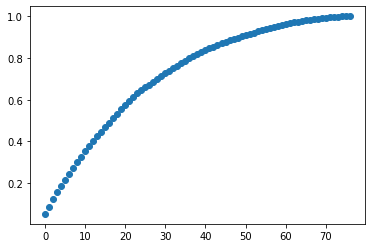

In [43]:
variables, importances = etc_importances(mes01, target01, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0    Item 8  0.044274
1    Item 2  0.087167
2    Item 5  0.128833
3    Item 7  0.167502
4    Item 6  0.202810
..      ...       ...
72  Item 45  0.994623
73  Item 50  0.996682
74  Item 49  0.998634
75  Item 51  1.000000
76  Item 75  1.000000

[77 rows x 2 columns]


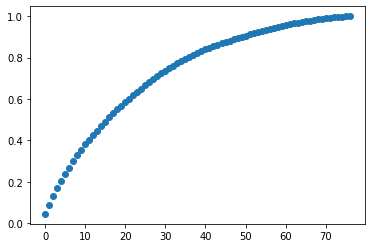

In [44]:
variables, importances = etc_importances(mes02, target02, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0   Item 17  0.039889
1    Item 3  0.078702
2    Item 2  0.117270
3    Item 1  0.151822
4    Item 5  0.185672
..      ...       ...
72  Item 48  0.997007
73  Item 21  0.998673
74  Item 50  0.999390
75  Item 51  0.999995
76  Item 75  1.000000

[77 rows x 2 columns]


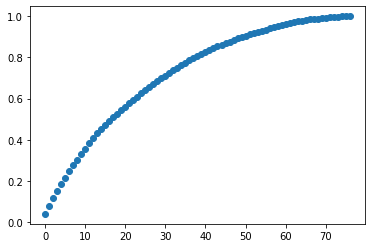

In [45]:
variables, importances = etc_importances(mes03, target03, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0    Item 2  0.068589
1    Item 5  0.102521
2    Item 8  0.134295
3    Item 6  0.165932
4    Item 7  0.197472
..      ...       ...
72  Item 45  0.996773
73  Item 49  0.998547
74  Item 51  0.999592
75  Item 50  0.999987
76  Item 75  1.000000

[77 rows x 2 columns]


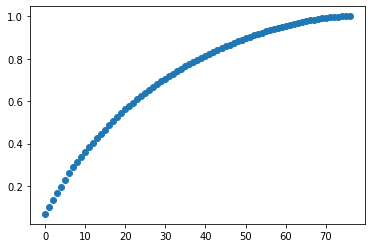

In [46]:
variables, importances = etc_importances(mes04, target04, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0    Item 1  0.039429
1    Item 3  0.075957
2    Item 8  0.112392
3   Item 17  0.148485
4    Item 7  0.182591
..      ...       ...
72  Item 49  0.996963
73  Item 21  0.998348
74  Item 51  0.999308
75  Item 50  0.999990
76  Item 75  1.000000

[77 rows x 2 columns]


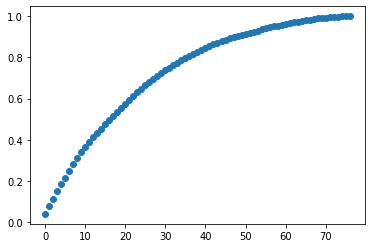

In [47]:
variables, importances = etc_importances(mes05, target05, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0    Item 1  0.038290
1    Item 3  0.075156
2   Item 17  0.110319
3    Item 2  0.144408
4    Item 8  0.177809
..      ...       ...
72  Item 21  0.996674
73  Item 48  0.998483
74  Item 51  0.999710
75  Item 50  1.000000
76  Item 75  1.000000

[77 rows x 2 columns]


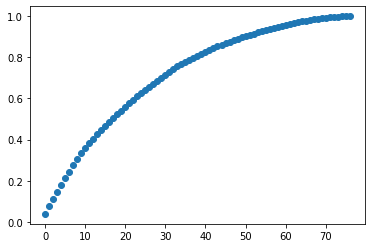

In [48]:
variables, importances = etc_importances(mes06, target06, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0    Item 1  0.048195
1    Item 2  0.090324
2    Item 8  0.117625
3    Item 6  0.144351
4   Item 67  0.170595
..      ...       ...
72  Item 49  0.996716
73  Item 48  0.998299
74  Item 51  0.999821
75  Item 50  0.999978
76  Item 75  1.000000

[77 rows x 2 columns]


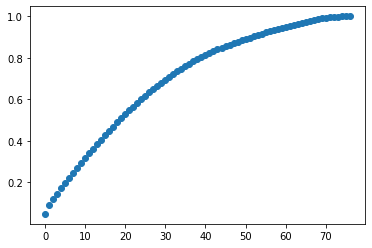

In [49]:
variables, importances = etc_importances(mes07, target07, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0    Item 3  0.044610
1   Item 17  0.083515
2   Item 18  0.118521
3    Item 8  0.152982
4    Item 7  0.186819
..      ...       ...
72  Item 49  0.996430
73  Item 45  0.998106
74  Item 50  0.999104
75  Item 51  0.999986
76  Item 75  1.000000

[77 rows x 2 columns]


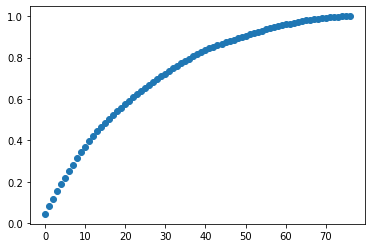

In [50]:
variables, importances = etc_importances(mes08, target08, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0    Item 2  0.051951
1    Item 7  0.094474
2    Item 8  0.135931
3    Item 5  0.175854
4    Item 3  0.215028
..      ...       ...
72  Item 49  0.996581
73  Item 48  0.998188
74  Item 51  0.999404
75  Item 50  0.999995
76  Item 75  1.000000

[77 rows x 2 columns]


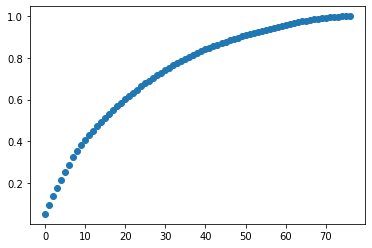

In [51]:
variables, importances = etc_importances(mes09, target09, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0    Item 1  0.045692
1    Item 2  0.084042
2    Item 3  0.120690
3    Item 7  0.154109
4   Item 17  0.187442
..      ...       ...
72  Item 45  0.996651
73  Item 48  0.998384
74  Item 51  0.999553
75  Item 50  0.999996
76  Item 75  1.000000

[77 rows x 2 columns]


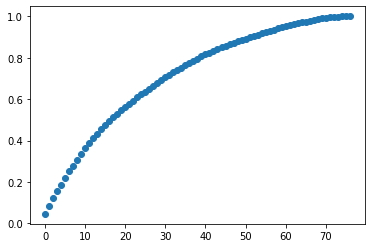

In [52]:
variables, importances = etc_importances(mes10, target10, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0    Item 2  0.055024
1    Item 5  0.098540
2    Item 1  0.136695
3    Item 3  0.174816
4    Item 6  0.210527
..      ...       ...
72  Item 48  0.996346
73  Item 21  0.997923
74  Item 50  0.999083
75  Item 51  1.000000
76  Item 75  1.000000

[77 rows x 2 columns]


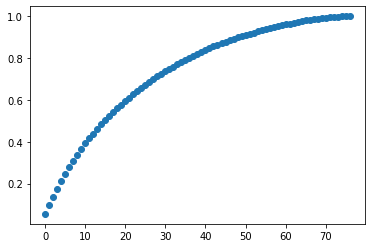

In [53]:
variables, importances = etc_importances(mes11, target11, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

          0         1
0    Item 1  0.051207
1    Item 5  0.099365
2    Item 8  0.146799
3    Item 6  0.189332
4    Item 7  0.230840
..      ...       ...
72  Item 21  0.996485
73  Item 49  0.997853
74  Item 51  0.998925
75  Item 50  0.999981
76  Item 75  1.000000

[77 rows x 2 columns]


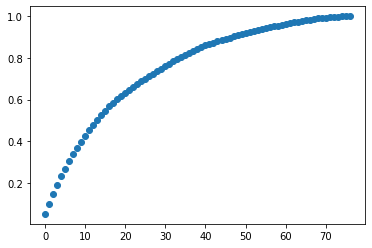

In [54]:
variables, importances = etc_importances(mes12, target12, n_estimators=300)
#plota a importância das variáveis
sum_importances = sum_and_plot_importances(variables, importances)
#mostra a ordem e a importância das variáveis no cálculo final, sendo a primeira a mais importante e a última a menos significativa
print(sum_importances)

# Modelagem

In [58]:
#faz a função para mostrar AUC e ROC
def rfc_test(X_train, y_train, n_estimators, cv):
  np.random.seed(1)
  rfc = RandomForestClassifier(n_estimators=n_estimators, random_state=0, n_jobs=-1, criterion='entropy', verbose=0)
  cv_scores = cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
  print('Média dos {} testes: '.format(cv), cv_scores.mean())
  return rfc

In [59]:
#teste o modelo dentro do próprio mês (o mesmo que foi treinado)
variables = locals()
for i in range(1,13):
  mes = str(i).zfill(2)
  rfc_test(variables["mes{0}".format(mes)], variables["target{0}".format(mes)], cv=20, n_estimators=340)

Média dos 20 testes:  0.5578431327690078
Média dos 20 testes:  0.6337514137908876
Média dos 20 testes:  0.5803095467042384
Média dos 20 testes:  0.5188318209634062
Média dos 20 testes:  0.5724499152953284
Média dos 20 testes:  0.5205661982218589
Média dos 20 testes:  0.545353223195454
Média dos 20 testes:  0.48537267216687247
Média dos 20 testes:  0.38888665428711416
Média dos 20 testes:  0.42881616551946233
Média dos 20 testes:  0.6896633887939615
Média dos 20 testes:  0.6398079509235195
